In [1]:
import pandas as pd
import torch.nn as nn
from tbnn.training_utils import early_stopped_tbnn_training_run
import torch
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import tbnn.models as models
import tbnn.devices as devices
import tbnn.dataloaders as dataloaders
import tbnn.losses as losses
import numpy as np
device = devices.get_device()

In [2]:
dataset_params = {'file': '/home/ryley/WDK/ML/dataset/turbulence_dataset_clean_split.csv',
                  'test_set': ['fp_3630','case_1p0','squareDuctQuad1_Re_2000'],
                }

df = pd.read_csv(dataset_params['file'])
df = df[df['Case'].isin(['fp_3030', 'case_1p0','squareDuctQuad1_Re_2000'])]



(array([457., 158., 218., 514., 282., 199., 156., 137., 110.,  73.]),
 array([1.23965320e-05, 2.64771314e-01, 5.29530232e-01, 7.94289149e-01,
        1.05904807e+00, 1.32380698e+00, 1.58856590e+00, 1.85332482e+00,
        2.11808374e+00, 2.38284266e+00, 2.64760157e+00]),
 <BarContainer object of 10 artists>)

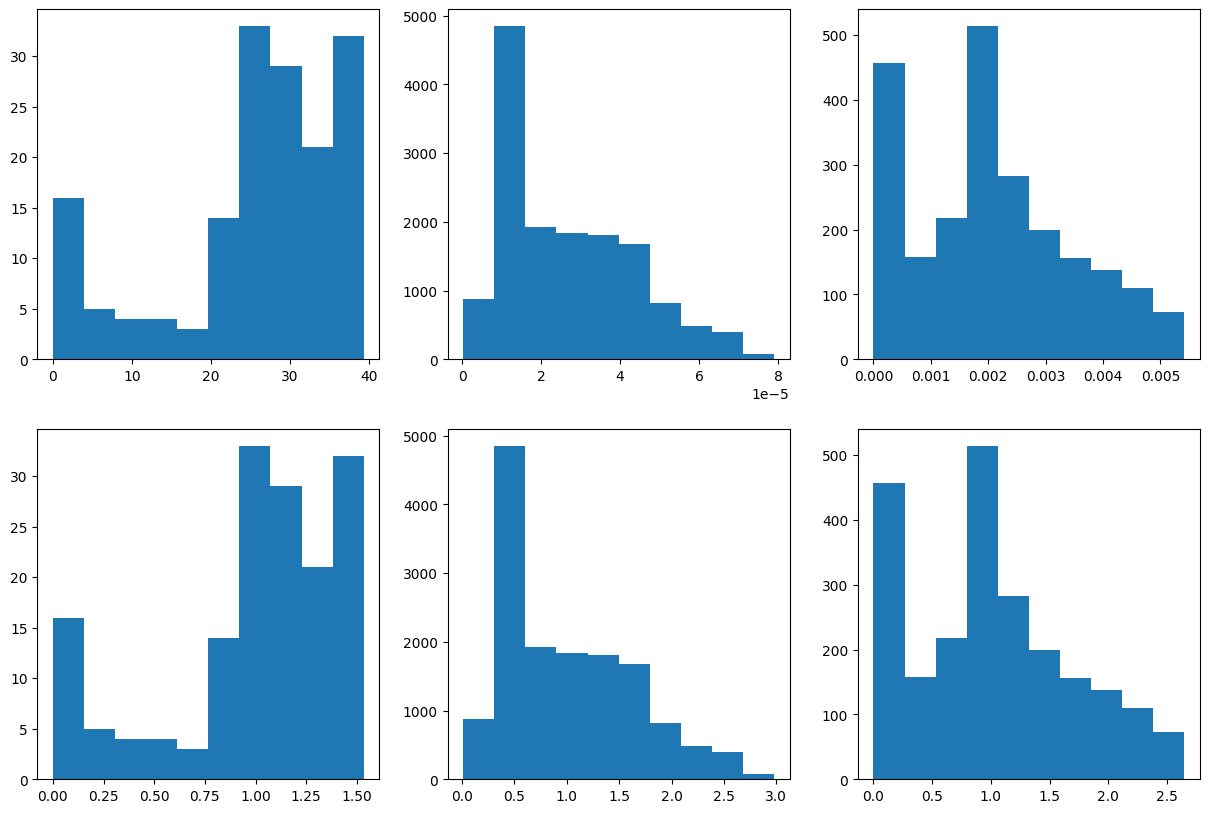

In [4]:
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(15,10))
axs[0,0].hist(df[df['Case']=='fp_3030']['DNS_k'])
axs[0,1].hist(df[df['Case']=='case_1p0']['DNS_k'])
axs[0,2].hist(df[df['Case']=='squareDuctQuad1_Re_2000']['DNS_k'])
axs[1,0].hist(df[df['Case']=='fp_3030']['DNS_khat'])
axs[1,1].hist(df[df['Case']=='case_1p0']['DNS_khat'])
axs[1,2].hist(df[df['Case']=='squareDuctQuad1_Re_2000']['DNS_khat'])

In [5]:
df = pd.concat([df[df['Case']=='fp_3030'].sample(100),df[df['Case']=='case_1p0'].sample(100)])
df_test = df
df_tv = df
print(f'Dataset: {len(df)}, test: {len(df_test)}, tv: {len(df_tv)}')


Dataset: 200, test: 200, tv: 200


Training points: 200, validation points 200
EPOCH    LR        TRAIN     VALID         MSE:T/V              RL:T/V         %NR_t/%NR_v
  1   5.000E-04   2.6379E-02   2.6379E-02   2.6379E-02 / 2.6379E-02   0.0000E+00 / 0.0000E+00   0.00% / 0.00%
 10   5.000E-04   2.4985E-02   2.4985E-02   2.4985E-02 / 2.4985E-02   0.0000E+00 / 0.0000E+00   0.00% / 0.00%
 20   5.000E-04   1.6797E-02   1.6797E-02   1.6797E-02 / 1.6797E-02   0.0000E+00 / 0.0000E+00   0.00% / 0.00%
 30   5.000E-04   1.0083E-02   1.0083E-02   1.0083E-02 / 1.0083E-02   0.0000E+00 / 0.0000E+00   0.00% / 0.00%
 40   5.000E-04   9.4231E-03   9.4231E-03   9.4231E-03 / 9.4231E-03   0.0000E+00 / 0.0000E+00   0.00% / 0.00%
 50   5.000E-04   8.9247E-03   8.9247E-03   8.9247E-03 / 8.9247E-03   0.0000E+00 / 0.0000E+00   0.00% / 0.00%
 60   5.000E-04   8.3648E-03   8.3648E-03   8.3648E-03 / 8.3648E-03   0.0000E+00 / 0.0000E+00   0.00% / 0.00%
 70   5.000E-04   7.6909E-03   7.6909E-03   7.6909E-03 / 7.6909E-03   0.0000E+00 / 0.0000E+00  

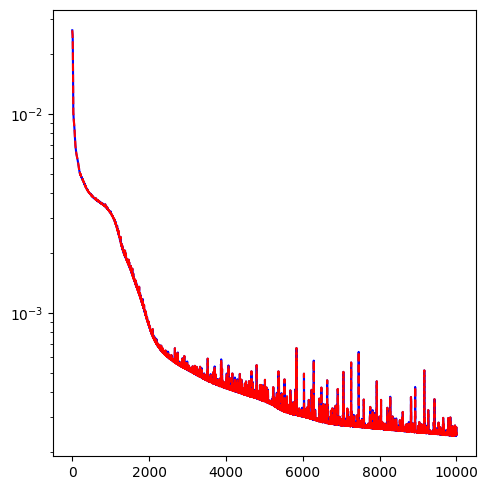

In [6]:
training_params = {'early_stopping_patience': 500,
                    'max_epochs': 10000,
                      'learning_rate': 0.0005,
                        'learning_rate_decay': 1.0,
                          'batch_size': 32,
                            'val_set': ['fp_3030', 'case_1p0']}

model_params = {'neurons': 20, 'n_hidden': 5, 'activation_function': nn.SiLU(),                 
                #'input_features': ['komegasst_q6','komegasst_q5','komegasst_I1_1','komegasst_I1_3','komegasst_I2_3','komegasst_I1_5']
                'input_features':['komegasst_I1_1',
'komegasst_I1_3',
'komegasst_I1_4',
'komegasst_I1_5',
#'komegasst_I1_16',
#'komegasst_I1_7',
#'komegasst_I1_9',
#'komegasst_I1_10',
#'komegasst_I1_12',
#'komegasst_I1_13',
#'komegasst_I1_16',
'komegasst_q5',
#'komegasst_q6',
]
}

model = models.TBNNiii(N = 10,
                input_dim = len(model_params['input_features']),
                n_hidden = model_params['n_hidden'],
                neurons = model_params['neurons'],
                activation_function = model_params['activation_function'],
                input_feature_names=model_params['input_features']
            ).to(device)

model, loss_vals, val_loss_vals  = early_stopped_tbnn_training_run(model = model,
                                                                   training_params = training_params,
                                                                   df_tv = df_tv,
                                                                   data_loader = dataloaders.aDataset, 
                                                                   loss_fn = losses.aLoss)

fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(loss_vals,'-',color='b')
ax.plot(val_loss_vals,'--',color='r')
ax.semilogy()
fig.tight_layout()
#fig.savefig(f'models/model_cluster_{cluster}.png',dpi=300)

In [8]:
from torch.utils.data import Dataset, DataLoader

df_train = df
df_val = df
tDs = dataloaders.bDataset(df_train, input_features=model_params['input_features'])
phllDs = dataloaders.bDataset(df[df['Case']=='case_1p0'], input_features=model_params['input_features'],scaler_X = tDs.scaler_X)
fpDs = dataloaders.bDataset(df[df['Case']=='fp_3030'], input_features=model_params['input_features'],scaler_X = tDs.scaler_X)

model.eval()
for inputs,labels_train in DataLoader(phllDs , shuffle=False, batch_size=df.__len__()):
    y_pred_phll, gn = model(*inputs)
    #print(labels_train)
    print(f'MSE_b PHLL: {losses.mseLoss(y_pred_phll,labels_train)}')

for inputs,labels_val in DataLoader(fpDs , shuffle=False, batch_size=df.__len__()):
    y_pred_fp, gn = model(*inputs)
    print(f'MSE_b fp: {losses.mseLoss(y_pred_fp,labels_train)}')

tDs = dataloaders.aDataset(df_train, input_features=model_params['input_features'])
phllDs = dataloaders.aDataset(df[df['Case']=='case_1p0'], input_features=model_params['input_features'],scaler_X = tDs.scaler_X)
fpDs = dataloaders.aDataset(df[df['Case']=='fp_3030'], input_features=model_params['input_features'],scaler_X = tDs.scaler_X)

model.eval()
for inputs,labels_train in DataLoader(phllDs , shuffle=False, batch_size=df.__len__()):
    y_pred_phll, gn = model(*inputs)
    #print(labels_train)
    print(f'MSE_a_khat PHLL: {losses.mseLoss_khat(y_pred_phll,*labels_train)}')

for inputs,labels_val in DataLoader(fpDs , shuffle=False, batch_size=df.__len__()):
    y_pred_fp, gn = model(*inputs)
    print(f'MSE_a_khat fp: {losses.mseLoss_khat(y_pred_fp,*labels_train)}')


tDs = dataloaders.aDataset(df_train, input_features=model_params['input_features'])
testDs = dataloaders.aDataset(df, input_features=model_params['input_features'],scaler_X = tDs.scaler_X)

model.eval()
for inputs,labels_train in DataLoader(testDs , shuffle=False, batch_size=df.__len__()):
    y_pred_test, gn = model(*inputs)
    #print(labels_train)
    print(f'MSE_a_whole: {losses.mseLoss_khat(y_pred_test,*labels_train)}')

df_test[f'pred_b_11_all'] = y_pred_test.detach().numpy()[:,0,0]
df_test[f'pred_b_12_all'] = y_pred_test.detach().numpy()[:,0,1]
df_test[f'pred_b_13_all'] = y_pred_test.detach().numpy()[:,0,2]
df_test[f'pred_b_22_all'] = y_pred_test.detach().numpy()[:,1,1]
df_test[f'pred_b_23_all'] = y_pred_test.detach().numpy()[:,1,2]
df_test[f'pred_b_33_all'] = y_pred_test.detach().numpy()[:,2,2]

df_test[f'pred_a_11_all'] = y_pred_test.detach().numpy()[:,0,0]*2*df_test[f'DNS_k']
df_test[f'pred_a_12_all'] = y_pred_test.detach().numpy()[:,0,1]*2*df_test[f'DNS_k']
df_test[f'pred_a_13_all'] = y_pred_test.detach().numpy()[:,0,2]*2*df_test[f'DNS_k']
df_test[f'pred_a_22_all'] = y_pred_test.detach().numpy()[:,1,1]*2*df_test[f'DNS_k']
df_test[f'pred_a_23_all'] = y_pred_test.detach().numpy()[:,1,2]*2*df_test[f'DNS_k']
df_test[f'pred_a_33_all'] = y_pred_test.detach().numpy()[:,2,2]*2*df_test[f'DNS_k']


MSE_b PHLL: 0.0018223371589556336
MSE_b fp: 0.018282575532794
MSE_a PHLL: 0.00046483069309033453
MSE_a fp: 0.027848033234477043
MSE_a_whole: 0.00024036067770794034


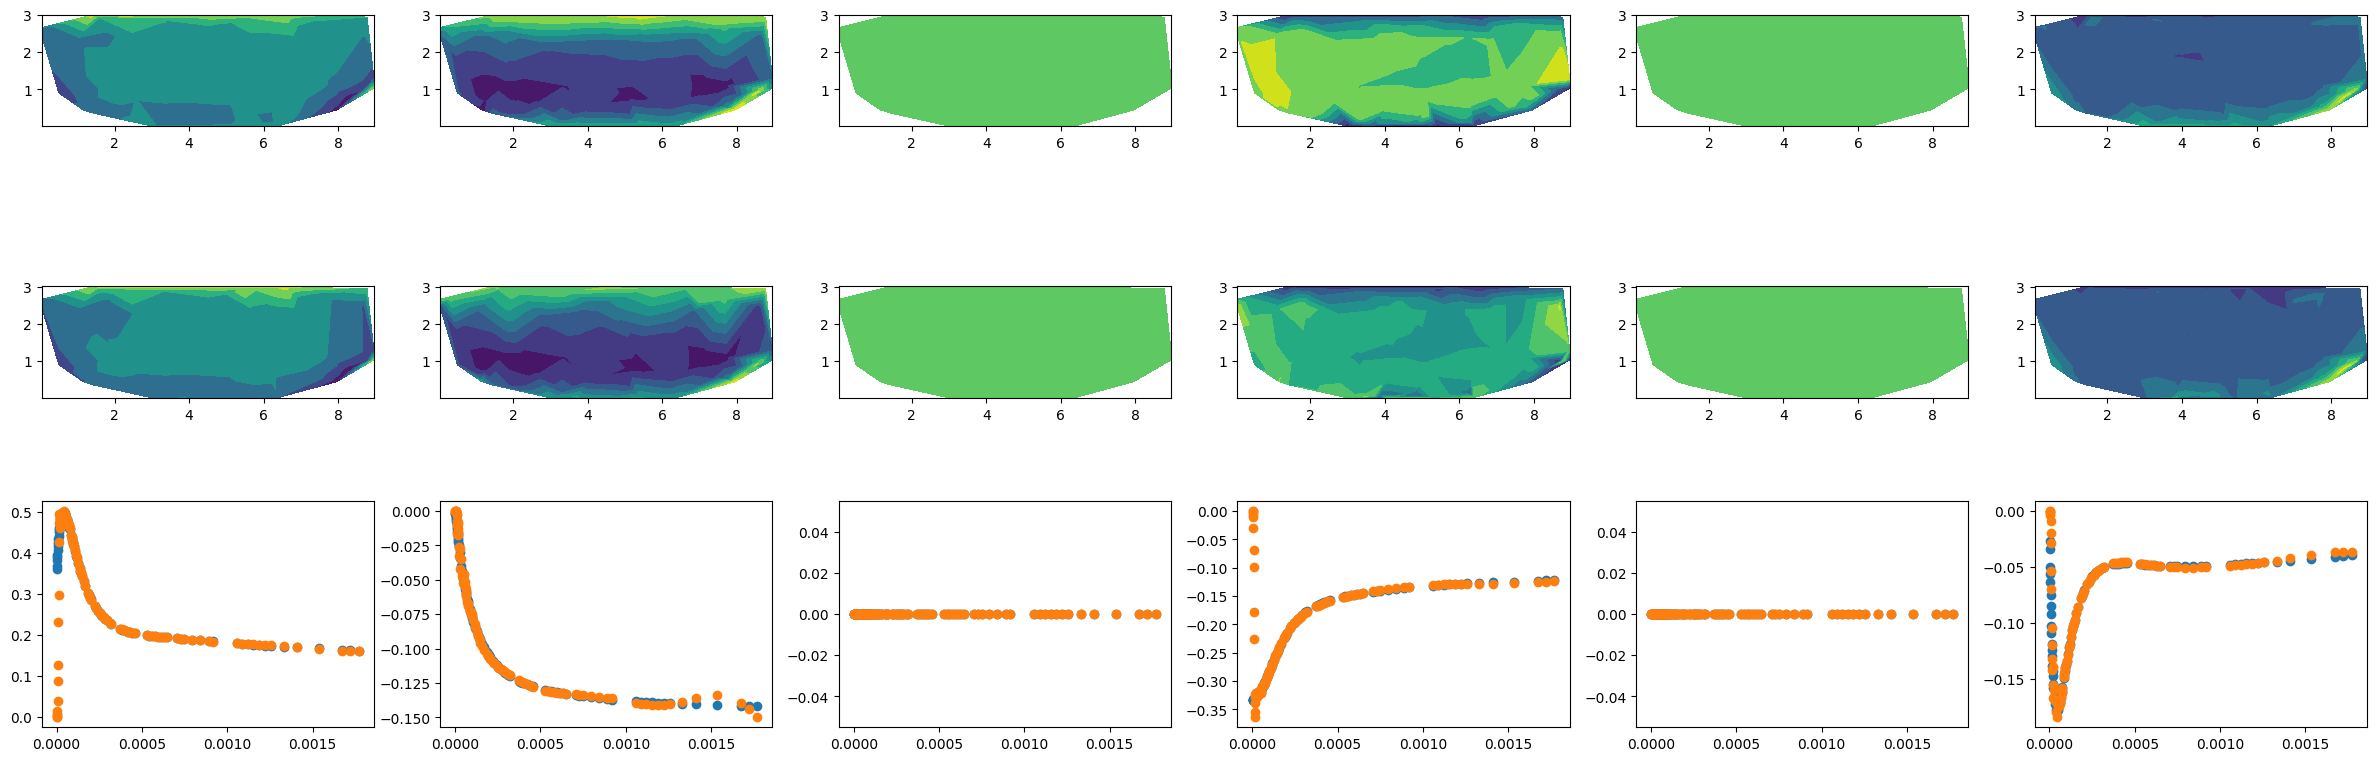

In [9]:
fig,axs=plt.subplots(nrows=3,ncols=6,figsize=(30,10))
dfp = df_test[df_test['Case']=='case_1p0']
dff = df_test[df_test['Case']=='fp_3030']
for i, scalar in enumerate(['b_11','b_12','b_13','b_22','b_23','b_33']):
    vmin = min(dfp[f'DNS_{scalar}'])
    vmax = max(dfp[f'DNS_{scalar}'])
    axs[0,i].tricontourf(dfp['komegasst_C_1'],dfp['komegasst_C_2'],dfp[f'DNS_{scalar}'])
    axs[1,i].tricontourf(dfp['komegasst_C_1'],dfp['komegasst_C_2'],dfp[f'pred_{scalar}_all'])
    axs[0,i].set_aspect(1)
    axs[1,i].set_aspect(1)

for i, scalar in enumerate(['b_11','b_12','b_13','b_22','b_23','b_33']):
    axs[2,i].scatter(dff['komegasst_C_2'],dff[f'DNS_{scalar}'])
    axs[2,i].scatter(dff['komegasst_C_2'],dff[f'pred_{scalar}_all'])
    #axs[0,i].set_aspect(1)
    #axs[1,i].set_aspect(1)



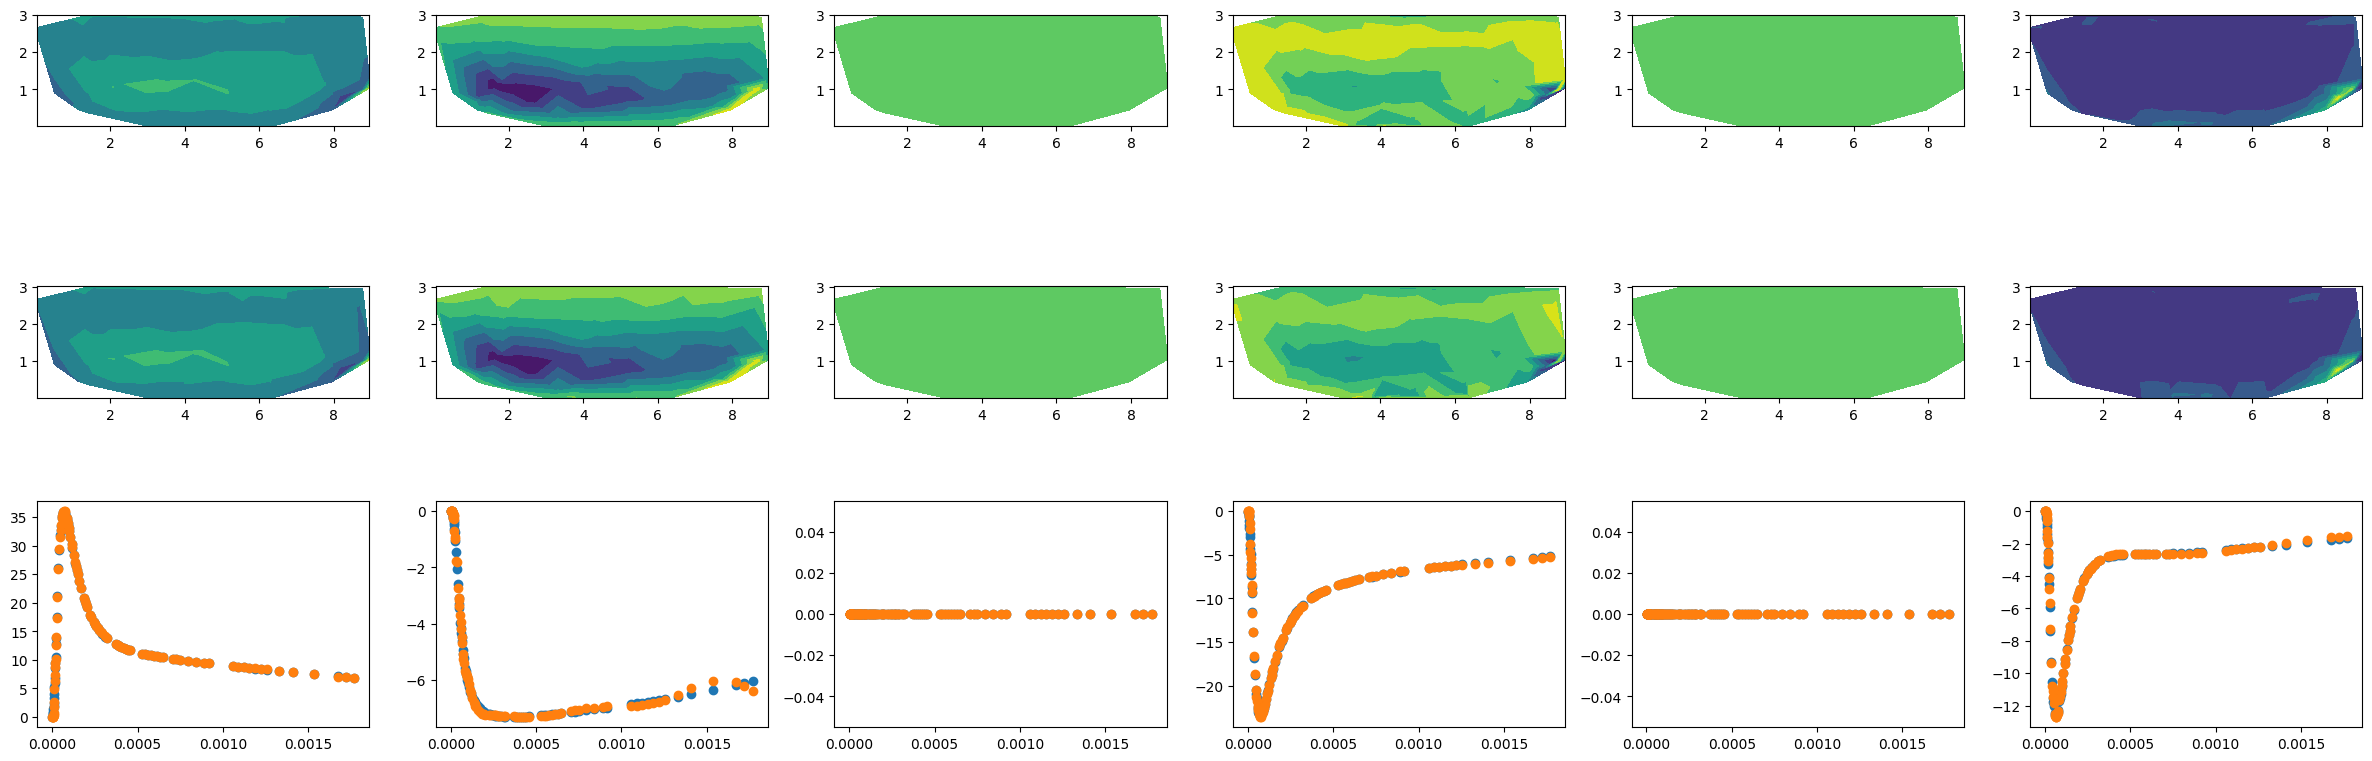

In [10]:
fig,axs=plt.subplots(nrows=3,ncols=6,figsize=(30,10))
dfp = df_test[df_test['Case']=='case_1p0']
dff = df_test[df_test['Case']=='fp_3030']
for i, scalar in enumerate(['a_11','a_12','a_13','a_22','a_23','a_33']):
    vmin = min(dfp[f'DNS_{scalar}'])
    vmax = max(dfp[f'DNS_{scalar}'])
    axs[0,i].tricontourf(dfp['komegasst_C_1'],dfp['komegasst_C_2'],dfp[f'DNS_{scalar}'])
    axs[1,i].tricontourf(dfp['komegasst_C_1'],dfp['komegasst_C_2'],dfp[f'pred_{scalar}_all'])
    axs[0,i].set_aspect(1)
    axs[1,i].set_aspect(1)

for i, scalar in enumerate(['a_11','a_12','a_13','a_22','a_23','a_33']):
    axs[2,i].scatter(dff['komegasst_C_2'],dff[f'DNS_{scalar}'])
    axs[2,i].scatter(dff['komegasst_C_2'],dff[f'pred_{scalar}_all'])
    #axs[0,i].set_aspect(1)
    #axs[1,i].set_aspect(1)

